In [1]:
import base64
from openai import OpenAI
import json
import re
from PIL import Image, ImageDraw

In [2]:
client = OpenAI()

## Trying To Get Open AI To Do Image Detection

In [3]:
# Function to encode the image from: https://platform.openai.com/docs/guides/vision
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [4]:
# Path to your image
image_path = "office-furniture.jpg"

In [5]:
# Getting the base64 string
base64_image = encode_image(image_path)

In [6]:
response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "What is in this image?",
        },
        {
          "type": "image_url",
          "image_url": {
            "url":  f"data:image/jpeg;base64,{base64_image}"
          },
        },
      ],
    }
  ],
)

In [7]:
print(response)

ChatCompletion(id='chatcmpl-AY1lPSQYjHfkOFrxESitfVW3Fl8AK', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The image shows a modern office space with a minimalist design. It features several desks and chairs arranged in an open layout, large windows allowing natural light, and a dark accent wall with a screen or monitor. The flooring appears to be wooden, contributing to the contemporary aesthetic. The office seems well-lit and spacious, promoting a professional work environment.', refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1732673295, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_3de1288069', usage=CompletionUsage(completion_tokens=68, prompt_tokens=8513, total_tokens=8581, completion_tokens_details=CompletionTokensDetails(audio_tokens=0, reasoning_tokens=0, accepted_prediction_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=Pr

In [8]:
response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "How many chairs are in this image?",
        },
        {
          "type": "image_url",
          "image_url": {
            "url":  f"data:image/jpeg;base64,{base64_image}"
          },
        },
      ],
    }
  ],
)

In [9]:
print(response)

ChatCompletion(id='chatcmpl-AY1lSJobC7vCUraYtwT24sjBgKllN', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="I'm unable to see the image or count the chairs in it. If you can describe the image or provide details, I might be able to help with related information!", refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1732673298, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_3de1288069', usage=CompletionUsage(completion_tokens=33, prompt_tokens=8515, total_tokens=8548, completion_tokens_details=CompletionTokensDetails(audio_tokens=0, reasoning_tokens=0, accepted_prediction_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))


In [10]:
system_instructions = """
As an image recognition expert, your task is to analyze images and provide 
output in JSON format with the following keys only: 'x', 'y', and 'details'.

- 'x' and 'y' should represent the coordinates of the center of the detected 
object within the image by pixels, with the reference point [0,0] at the top left corner.
- 'details' should provide a brief description of the object identified in the image.

For cases involving the identification of people or animals, focus on locating and 
identifying the face of the person or animal. Ensure that the given 'x' and 'y' 
coordinates correspond to the center of the identified face.

Please adhere strictly to this output structure:
{
  "x": value,
  "y": value,
  "details": "Description"
}

Note: Do not include any additional data or keys outside of what has been specified.
"""

In [11]:
response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
        "role": "system",
        "content": system_instructions
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "Detect chairs",
        },
        {
          "type": "image_url",
          "image_url": {
            "url":  f"data:image/jpeg;base64,{base64_image}"
          },
        },
      ],
    }
  ],
)

In [12]:
r = response.choices[0].message.content

In [13]:
chairs = json.loads(re.sub(r'\s+', ' ', r.strip('```').replace('\n', '').strip('json')))

In [14]:
chairs

[{'x': 100, 'y': 200, 'details': 'Office chair'},
 {'x': 180, 'y': 200, 'details': 'Office chair'},
 {'x': 260, 'y': 200, 'details': 'Office chair'},
 {'x': 340, 'y': 200, 'details': 'Office chair'},
 {'x': 420, 'y': 200, 'details': 'Office chair'}]

In [15]:
image = Image.open(image_path)

In [16]:
draw = ImageDraw.Draw(image)

In [17]:
dot_radius = 2
for c in chairs:
    draw.ellipse(
        (c['x'] - dot_radius, c['y'] - dot_radius, 
         c['x'] + dot_radius, c['y'] + dot_radius),
        fill="red",
        outline="red"
    )

In [18]:
image.show()

## How About Text Embeddings

Remember the NY Times classifier? What if we used OpenAI's embeddings instead?

In [31]:
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [22]:
def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [23]:
df = pd.read_excel("/Users/johntemplon/Downloads/dataset.xlsx")

In [24]:
nyt_df = df.loc[lambda x: x['publication'] == 'New York Times'].copy()

In [25]:
nyt_df.head()

,Unnamed: 0,id,human_summary,publication,author,date,year,month,theme,content
0,0,17283,In successfully seeking a temporary halt in th...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,politics,WASHINGTON — Congressional Republicans have...
1,0,17284,Officers put her in worse danger some months l...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,crime,"After the bullet shells get counted, the blood..."
2,0,17285,The film striking appearance had been created ...,New York Times,Margalit Fox,2017-01-06,2017.0,1.0,entertainment,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,0,17286,The year was only days old when the news came ...,New York Times,William McDonald,2017-04-10,2017.0,4.0,entertainment,"Death may be the great equalizer, but it isn’t..."
4,0,17287,If North Korea conducts a test in coming month...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,politics,"SEOUL, South Korea — North Korea’s leader, ..."


In [27]:
# This takes a minute, because it has to go to OpenAI 999 times
nyt_df['embeddings'] = nyt_df['content'].apply(lambda x: get_embedding(x))

In [29]:
inertias = []

In [32]:
for i in range(1,14):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(nyt_df["embeddings"].to_list())
    inertias.append(kmeans.inertia_)

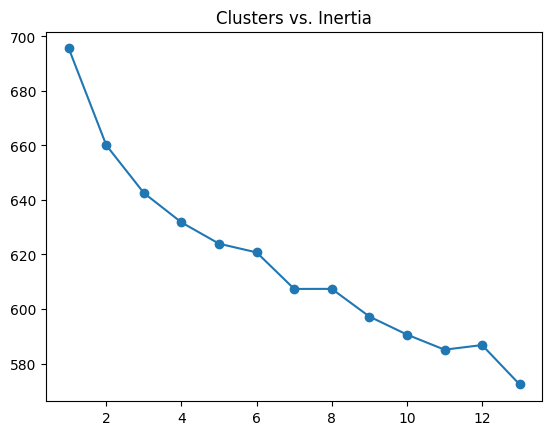

In [33]:
plt.plot(range(1,14), inertias, marker='o')
plt.title('Clusters vs. Inertia')
plt.show()

We used 7 clusters last time and there's a good argument for it here! (Though also 11!)

In [55]:
kmeans = KMeans(n_clusters=7, random_state=42)

In [56]:
kmeans.fit(nyt_df["embeddings"].tolist())

KMeans(n_clusters=7, random_state=42)

In [57]:
nyt_df['group'] = kmeans.labels_

These results look pretty similar to what we got with our own embeddings, except Politics is mostly contained to one cluster. (Cluster 0 has 140 politics articles and no cluster in our other example had more than 87.)

In [58]:
nyt_df.groupby('group')['theme'].value_counts().to_frame().unstack().fillna(0)

count                                                              \
theme accidents architecture  art business crime entertainment environment    
group                                                                         
0           1.0          0.0  0.0     53.0  12.0          17.0          0.0   
1           0.0          0.0  0.0     17.0   6.0          62.0          0.0   
2           0.0          1.0  0.0     19.0  32.0           2.0          0.0   
3           1.0          0.0  1.0     14.0   9.0          18.0          0.0   
4           0.0          1.0  0.0     26.0  38.0           9.0          0.0   
5           0.0          0.0  0.0     24.0   1.0           4.0          0.0   
6           2.0          2.0  1.0     55.0  12.0          41.0          1.0   

                                                                 
theme health   law lifestyle politics science sports technology  
group                                                            
0        0.0   8.0      11.0    140.0     0.0    1.0        3.0  
1        0.0   2.0       5.0     16.0     0.0    9.0        2.0  
2        0.0   8.0       6.0     50.0     1.0    5.0        0.0  
3        2.0   4.0      18.0      8.0     8.0    2.0        3.0  
4        0.0  11.0       5.0     25.0     2.0    4.0        2.0  
5        0.0   2.0       3.0     51.0     2.0    0.0        0.0  
6        0.0   6.0      30.0     34.0    11.0    9.0        8.0

## How About Text Analysis

How well will OpenAI's model do with sentiment analysis? We already have a annotated dataset that can help us answer that question.

In [61]:
df = pd.read_csv('annoted_data.csv')

clean_df = df.loc[lambda x: x['review_id'] != 'review_id'].copy()
clean_df['sentiment'] = clean_df['sentiment'].apply(lambda x: x.strip() if x in ['pos', 'neg'] else 'pos')

In [63]:
clean_df.head()

,review_id,business_id,text,date,sentiment,annotator
1,LaO2ZSqc6rN3AZmDXcgU2Q,FpyjR9TiaO3JyynpF-y-7g,Service and food are meh. I came here once in ...,2022-01-08 14:52:13,neg,cf
2,m8wfNY6s0YaQCF08Ad-row,3YqUe2FTCQr0pPVK8oCv6Q,"After so much talk from my sister, I had to co...",2022-01-12 2:10:19,pos,cf
3,FgepcIqW9uWMBRGX_4xCig,dECEn8-37NHSyZbq2a1nQw,Amazing gem in the rough! They have a variety ...,2022-01-15 20:47:05,pos,cf
4,31DWipZCMv4M8RAU7LIb1Q,ttDkz3SO_58bAkEp7rSsNA,Hidden is key word. Upper floor of gym buil...,2022-01-09 21:45:48,pos,cf
5,9sMReBdqs47Mf3mrA2CzZA,1VPpbFms0augW1raf8cycw,"The staff was friendly and helpful, the boat r...",2022-01-16 23:51:15,neg,cf


In [65]:
system_instructions = """
    As a linguistics expert, your task is to analyze passages of text and determine whether they contain positive or negative sentiment.
    Each text block can only have one result. You should respond either:

    'pos' for positive
    'neg' for negative

    Do not provide any additional information.
"""

In [68]:
def sentiment_analysis(text):
    response = client.chat.completions.create(
      model="gpt-4o-mini",
      messages=[
        {
            "role": "system",
            "content": system_instructions
        },
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": f"{text}",
            },
          ],
        }
      ],
    )
    return response.choices[0].message.content

In [70]:
clean_df['openai_sent'] = clean_df['text'].apply(lambda x: sentiment_analysis(x))

In [72]:
clean_df.apply(lambda x: x['sentiment'] == x['openai_sent'], axis=1).mean()

0.927461139896373

In [73]:
clean_df.loc[lambda x: x['sentiment'] != x['openai_sent']]

,review_id,business_id,text,date,sentiment,annotator,openai_sent
26,jpfgRBZ9yImfgPaU-zRybQ,4r4B36aNolZKmMi8yZzUww,Patriots stay away. \n\nDr. Jermey is a weak m...,2022-01-08 11:34:25,pos,LM,neg
29,wnd_xWdBDlTl_uQPy68ZuA,4TqfdroNe4CqKAn-b4uUIA,Houses are generally people's greatest purchas...,2022-01-07 13:10:50,pos,LM,neg
36,7zte3L0bc7YU8_UdgxLcAA,eiaa4Giul1y4FUKQYxpS2g,This cemetery is not kept well. The upkeep and...,2022-01-10 01:59:25,pos,LM,neg
40,_1EDZqawclhlz7InGJ8-_g,RX14pCbmXIt08JWKuOCltg,This place would not see my 6yo son because he...,2022-01-11 22:53:03,pos,LM,neg
42,1I-BRJbGl7cUXQdIhh_LQA,J2yUdxRA0FuQFsky-UF1ug,I left a complaint on the customer service sup...,2022-01-16 21:35:05,pos,LM,neg
49,rKaxip9dT_ayW4T_OXFUqQ,_LoYXMFxkbmrpAP74d81Dw,Went in because we were both dying of hunger. ...,2022-01-01 00:10:16,pos,LM,neg
57,bk2-d3G2hx56jIJ_jMZpmw,oVr68YLI0PMSkEc_SHMkFA,The server was fantastic in the lounge. She wa...,1/9/22 15:18,pos,reviews-MR,neg
61,BitQPxc7pCsaUlhpQwWL0w,n1sTAd-dxmgOCctrki9dMg,was a bit frustrated by our experience. Server...,1/18/22 4:32,pos,reviews-MR,neg
71,ZJifvLo0-QSkQ5GrY2ERGw,weJrl7T7Q_mmgG-9GlL9rQ,We took our dog to this groomer three times. T...,1/2/22 19:54,pos,reviews-MR,neg
74,vH9ephP2n-T5E9Ae37MmXQ,V3W_x72jYYf20GyoFdVRyQ,Stayed one night for NYE. COVID protocols are ...,1/1/22 21:38,pos,reviews-MR,neg


---

---

---